Starting training at 2025-04-05 12:56:49
Will train for 100000 iterations with evaluation every 500 steps

2025-04-05 12:56:55, Iteration: 500
  sine: MSE = 0.6079
  exp: MSE = 0.1498
  polynomial: MSE = 1.0639
  straight_line: MSE = 0.4287
  Average MSE across all families: 0.5626

2025-04-05 12:57:26, Iteration: 1000
  sine: MSE = 0.5807
  exp: MSE = 0.1490
  polynomial: MSE = 1.0517
  straight_line: MSE = 0.4183
  Average MSE across all families: 0.5499

2025-04-05 12:57:59, Iteration: 1500
  sine: MSE = 0.5775
  exp: MSE = 0.1437
  polynomial: MSE = 1.0445
  straight_line: MSE = 0.4077
  Average MSE across all families: 0.5433

2025-04-05 12:58:30, Iteration: 2000
  sine: MSE = 0.5332
  exp: MSE = 0.1225
  polynomial: MSE = 0.9922
  straight_line: MSE = 0.3778
  Average MSE across all families: 0.5064

2025-04-05 12:59:02, Iteration: 2500
  sine: MSE = 0.4710
  exp: MSE = 0.0677
  polynomial: MSE = 0.8637
  straight_line: MSE = 0.2319
  Average MSE across all families: 0.4086

2025

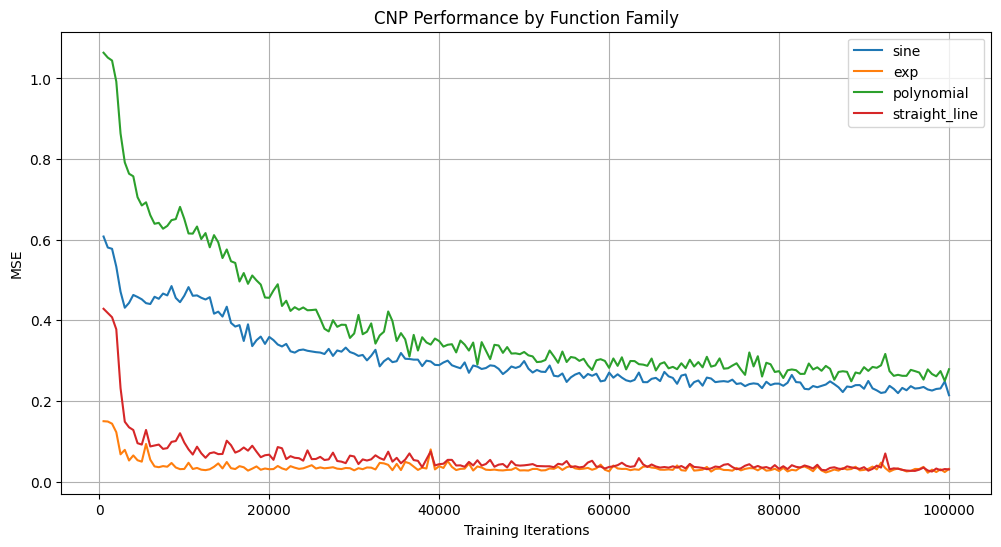

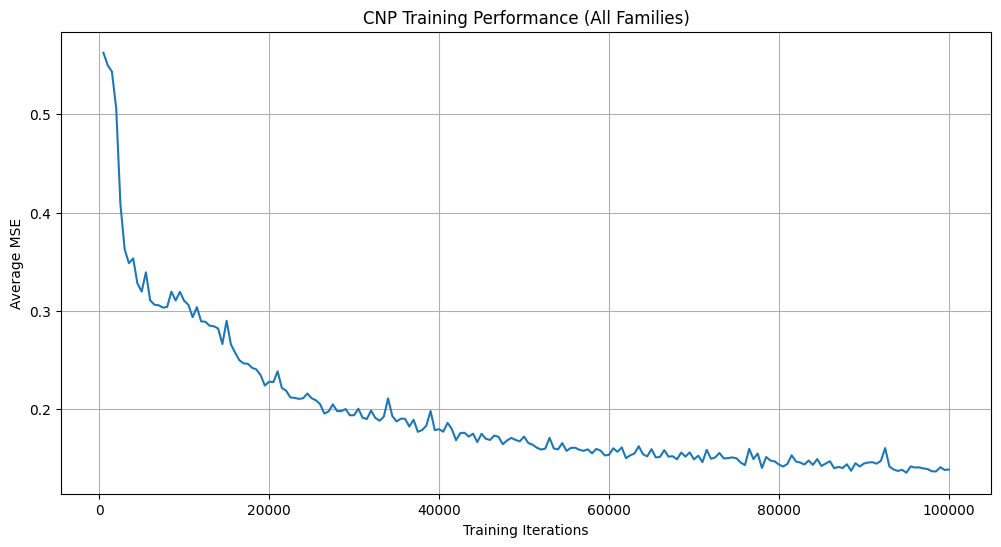


Final Evaluation and Visualization:


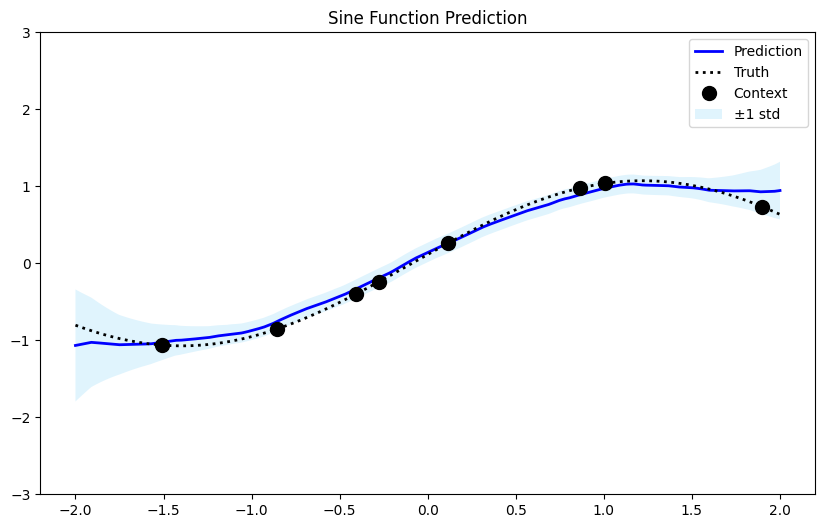

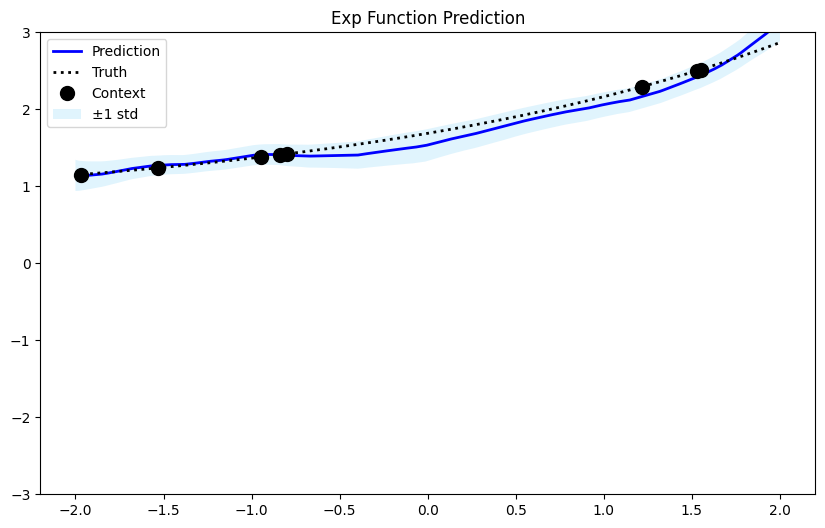

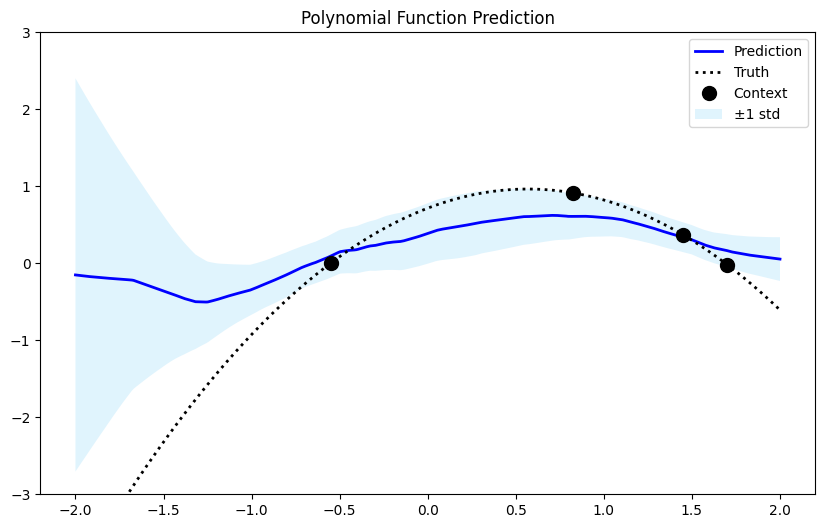

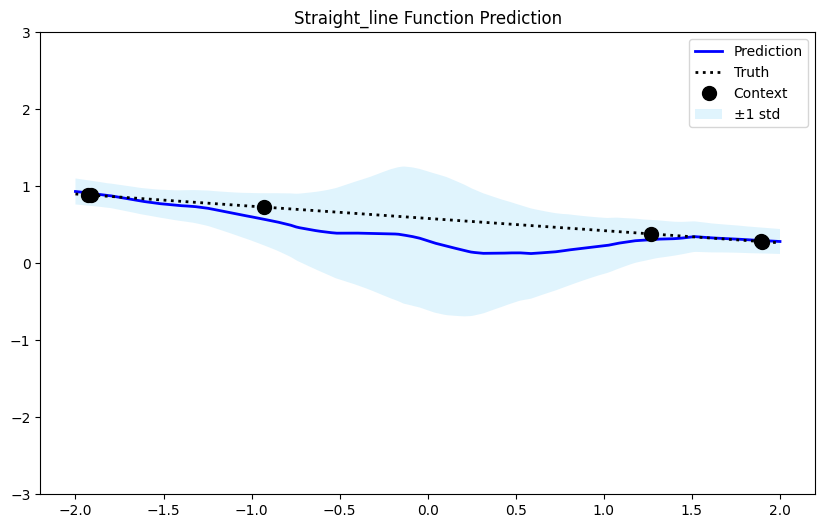

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families with mixed sampling."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data with mixed function families."""

        # Sample number of context points
        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1))) * 4 - 2  # unif[-2, 2]

        # Randomly select function family if not specified
        if function_family is None:
            function_family = random.choice(self._function_families)

        # Generate different function types with random parameters
        if function_family == FunctionFamily.SINE:
            # Random amplitude (0.5-1.5), frequency (0.5-2.5), phase (0-2pi)
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            # Random scale (-0.5 to 0.5) and shift (-1 to 1)
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            # Random quadratic coefficients (-1 to 1)
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            # Random slope (-1 to 1) and intercept (-2 to 2)
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        # Split into context and target points
        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100

# Create fixed test datasets for each function family
fixed_test_datasets = {}
function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Initialize test data generators
test_readers = {
    family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
    for family in function_families
}

# Generate fixed test datasets
for family in function_families:
    fixed_test_datasets[family] = [
        test_readers[family].generate_curves(family)[0]  # [0] because we don't need the family label
        for _ in range(NUM_TEST_TASKS)
    ]

# Model and Optimizer
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_tasks = []
family_mses = {family: [] for family in function_families}

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on a list of test datasets and returns the average MSE."""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)

    if family_name is not None:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")

    return avg_mse

# Training loop
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Will train for {TRAINING_ITERATIONS} iterations with evaluation every {EVAL_AFTER} steps")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Generate training batch with mixed function families
    data_train, family = train_reader.generate_curves()

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, Iteration: {it + 1}")

        # Evaluate on all function families
        current_mses = {}
        total_mse = 0.0
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_tasks.append(it + 1)

        print(f"  Average MSE across all families: {avg_mse:.4f}")

# Plot training curves
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_tasks, family_mses[family], label=family)
plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family')
plt.legend()
plt.grid(True)
plt.show()

# Plot overall training curve
plt.figure(figsize=(12, 6))
plt.plot(training_tasks, mse_values)
plt.xlabel('Training Iterations')
plt.ylabel('Average MSE')
plt.title('CNP Training Performance (All Families)')
plt.grid(True)
plt.show()

# Visualize predictions for each function family
print("\nFinal Evaluation and Visualization:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families with mixed sampling."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data with mixed function families."""

        # Sample number of context points
        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1))) * 4 - 2  # unif[-2, 2]

        # Randomly select function family if not specified
        if function_family is None:
            function_family = random.choice(self._function_families)

        # Generate different function types with random parameters
        if function_family == FunctionFamily.SINE:
            # Random amplitude (0.5-1.5), frequency (0.5-2.5), phase (0-2pi)
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            # Random scale (-0.5 to 0.5) and shift (-1 to 1)
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            # Random quadratic coefficients (-1 to 1)
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            # Random slope (-1 to 1) and intercept (-2 to 2)
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        # Split into context and target points
        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100

# Create fixed test datasets for each function family
fixed_test_datasets = {}
function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Initialize test data generators
test_readers = {
    family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
    for family in function_families
}

# Generate fixed test datasets
for family in function_families:
    fixed_test_datasets[family] = [
        test_readers[family].generate_curves(family)[0]  # [0] because we don't need the family label
        for _ in range(NUM_TEST_TASKS)
    ]

# Model and Optimizer
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_tasks = []
family_mses = {family: [] for family in function_families}

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on a list of test datasets and returns the average MSE."""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)

    if family_name is not None:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")

    return avg_mse

# Training loop
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Will train for {TRAINING_ITERATIONS} iterations with evaluation every {EVAL_AFTER} steps")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Generate training batch with mixed function families
    data_train, family = train_reader.generate_curves()

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, Iteration: {it + 1}")

        # Evaluate on all function families
        current_mses = {}
        total_mse = 0.0
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_tasks.append(it + 1)

        print(f"  Average MSE across all families: {avg_mse:.4f}")

# Plot training curves
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_tasks, family_mses[family], label=family)
plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family')
plt.legend()
plt.grid(True)
plt.show()

# Plot overall training curve
plt.figure(figsize=(12, 6))
plt.plot(training_tasks, mse_values)
plt.xlabel('Training Iterations')
plt.ylabel('Average MSE')
plt.title('CNP Training Performance (All Families)')
plt.grid(True)
plt.show()

# Visualize predictions for each function family
print("\nFinal Evaluation and Visualization:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

Starting training at 2025-04-07 19:53:27
Training for 100000 iterations with 100-iteration blocks

Block 1: Training on straight_line

Block 2: Training on straight_line

Block 3: Training on sine

Block 4: Training on polynomial

Block 5: Training on straight_line

Evaluation at iteration 500:
  sine: MSE = 0.6576
  exp: MSE = 0.1678
  polynomial: MSE = 1.0806
  straight_line: MSE = 0.4219
Average MSE across all families: 0.5820

Block 6: Training on straight_line

Block 7: Training on polynomial

Block 8: Training on straight_line

Block 9: Training on polynomial

Block 10: Training on exp

Evaluation at iteration 1000:
  sine: MSE = 0.6065
  exp: MSE = 0.1502
  polynomial: MSE = 1.0664
  straight_line: MSE = 0.4178
Average MSE across all families: 0.5602

Block 11: Training on exp

Block 12: Training on polynomial

Block 13: Training on exp

Block 14: Training on sine

Block 15: Training on polynomial

Evaluation at iteration 1500:
  sine: MSE = 0.5962
  exp: MSE = 0.1451
  polynomi

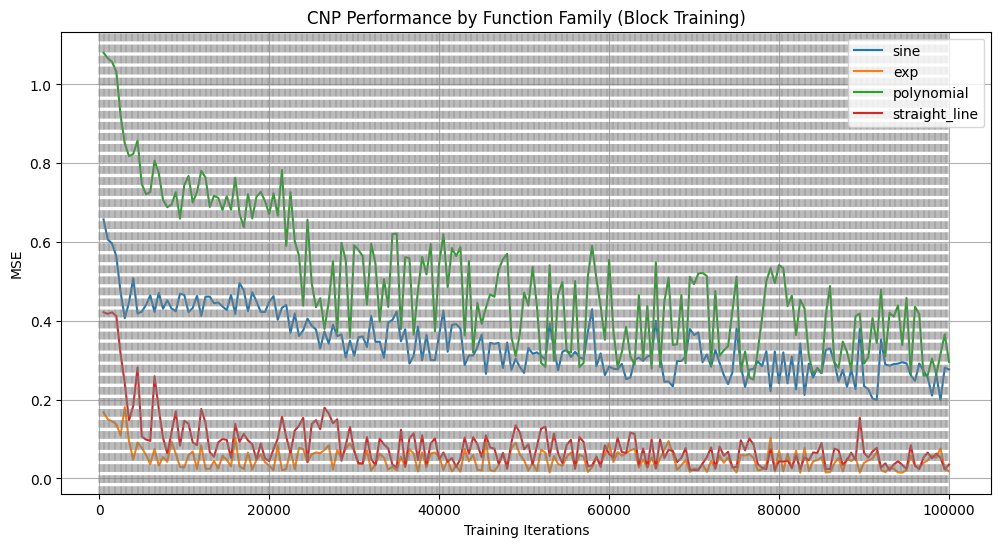

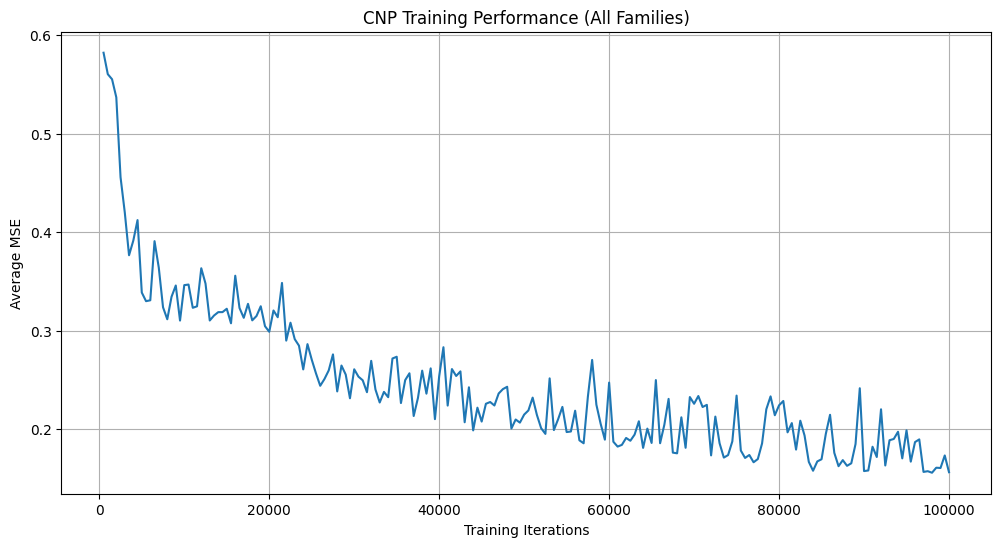


Final Evaluation:
  sine: MSE = 0.2767
sine test MSE: 0.2767


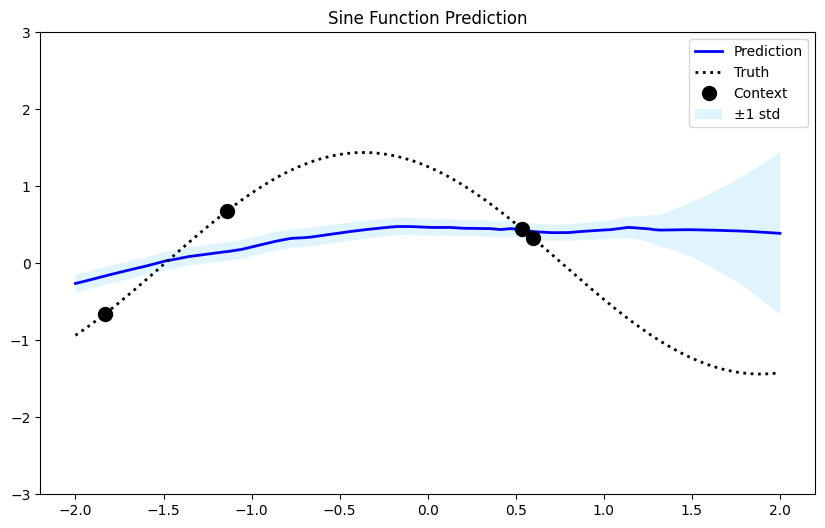

  exp: MSE = 0.0183
exp test MSE: 0.0183


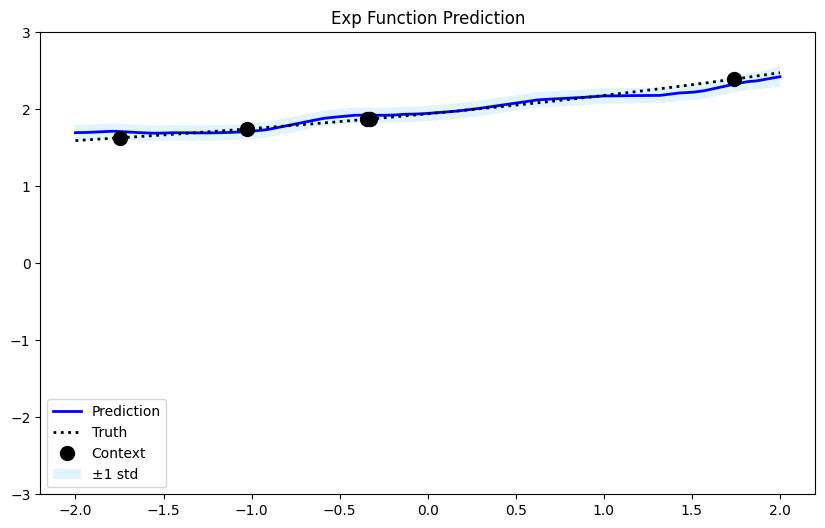

  polynomial: MSE = 0.2958
polynomial test MSE: 0.2958


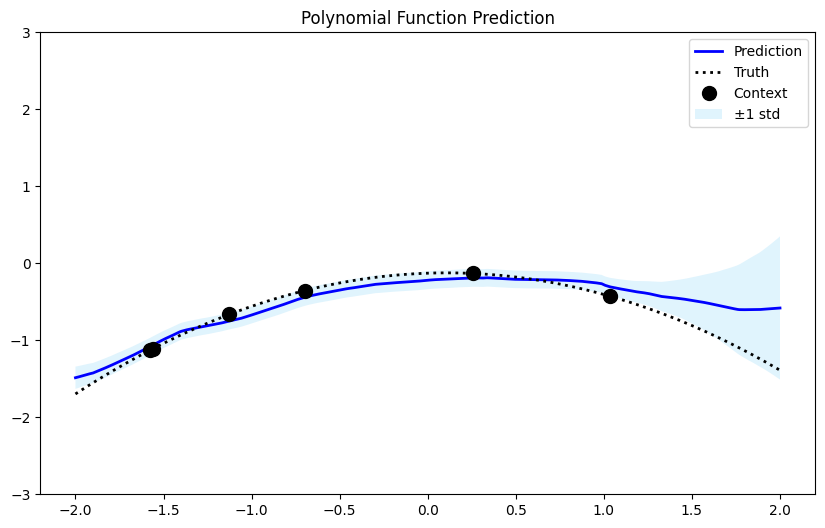

  straight_line: MSE = 0.0352
straight_line test MSE: 0.0352


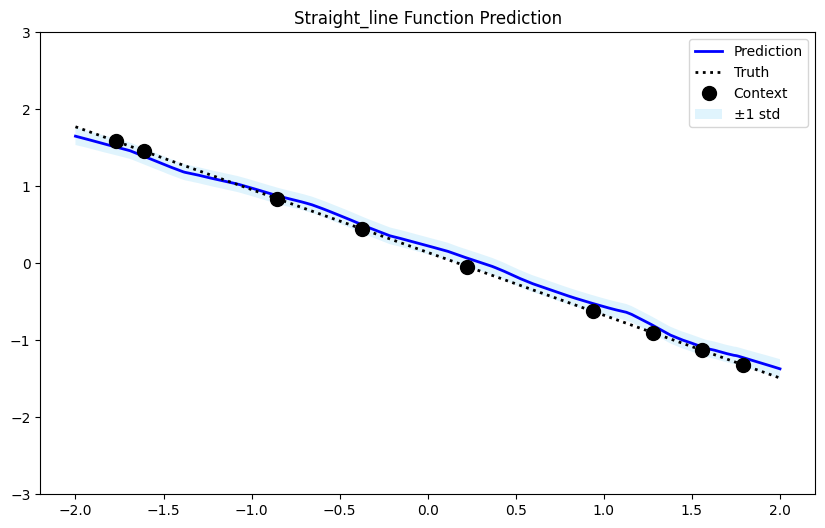

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data."""

        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1)) * 4 - 2)  # unif[-2, 2]

        if function_family is None:
            function_family = random.choice(self._function_families)

        if function_family == FunctionFamily.SINE:
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
BLOCK_SIZE = 100  # Number of iterations per function family
EVAL_AFTER = 500  # Evaluate every 500 iterations
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100

# Create fixed test datasets for each function family
fixed_test_datasets = {}
function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Initialize test data generators
test_readers = {
    family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
    for family in function_families
}

# Generate fixed test datasets
for family in function_families:
    fixed_test_datasets[family] = [
        test_readers[family].generate_curves(family)[0]
        for _ in range(NUM_TEST_TASKS)
    ]

# Model and Optimizer
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_blocks = []
family_mses = {family: [] for family in function_families}
current_family = None

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on test datasets and returns average MSE."""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)

    if family_name is not None:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")

    return avg_mse

# Training loop with blocks
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {TRAINING_ITERATIONS} iterations with {BLOCK_SIZE}-iteration blocks")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Switch family at the start of each block
    if it % BLOCK_SIZE == 0:
        current_family = random.choice(function_families)
        print(f"\nBlock {it // BLOCK_SIZE + 1}: Training on {current_family}")

    # Generate training batch from current family
    data_train, _ = train_reader.generate_curves(current_family)

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation (every EVAL_AFTER iterations)
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1}:")
        current_mses = {}
        total_mse = 0.0

        # Evaluate on all function families
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print(f"Average MSE across all families: {avg_mse:.4f}")

# Plot training curves per family
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_blocks, family_mses[family], label=family)

# Add vertical lines for block boundaries
for block_start in range(0, TRAINING_ITERATIONS, BLOCK_SIZE):
    if block_start < training_blocks[-1]:
        plt.axvline(block_start, color='gray', linestyle='--', alpha=0.3)

plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family (Block Training)')
plt.legend()
plt.grid(True)
plt.show()

# Plot overall training curve
plt.figure(figsize=(12, 6))
plt.plot(training_blocks, mse_values)
plt.xlabel('Training Iterations')
plt.ylabel('Average MSE')
plt.title('CNP Training Performance (All Families)')
plt.grid(True)
plt.show()

# Final evaluation and visualization
print("\nFinal Evaluation:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    # Evaluate
    test_mse = evaluate_model(model, fixed_test_datasets[family], family)
    print(f"{family} test MSE: {test_mse:.4f}")

    # Visualize
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

Starting training at 2025-04-11 16:40:48
Training for 100000 iterations with 100-iteration blocks

Evaluation at iteration 500 (Current family: straight_line):
  sine: MSE = 0.6571
  exp: MSE = 0.1595
  polynomial: MSE = 1.0896
  straight_line: MSE = 0.4338
Average MSE across all families: 0.5850

Evaluation at iteration 1000 (Current family: polynomial):
  sine: MSE = 0.5833
  exp: MSE = 0.1628
  polynomial: MSE = 1.0584
  straight_line: MSE = 0.4411
Average MSE across all families: 0.5614

Evaluation at iteration 1500 (Current family: exp):
  sine: MSE = 0.5940
  exp: MSE = 0.1516
  polynomial: MSE = 1.0940
  straight_line: MSE = 0.4738
Average MSE across all families: 0.5784

Evaluation at iteration 2000 (Current family: sine):
  sine: MSE = 0.5361
  exp: MSE = 0.2161
  polynomial: MSE = 1.0763
  straight_line: MSE = 0.5011
Average MSE across all families: 0.5824

Evaluation at iteration 2500 (Current family: straight_line):
  sine: MSE = 0.5369
  exp: MSE = 0.1337
  polynomial: MSE

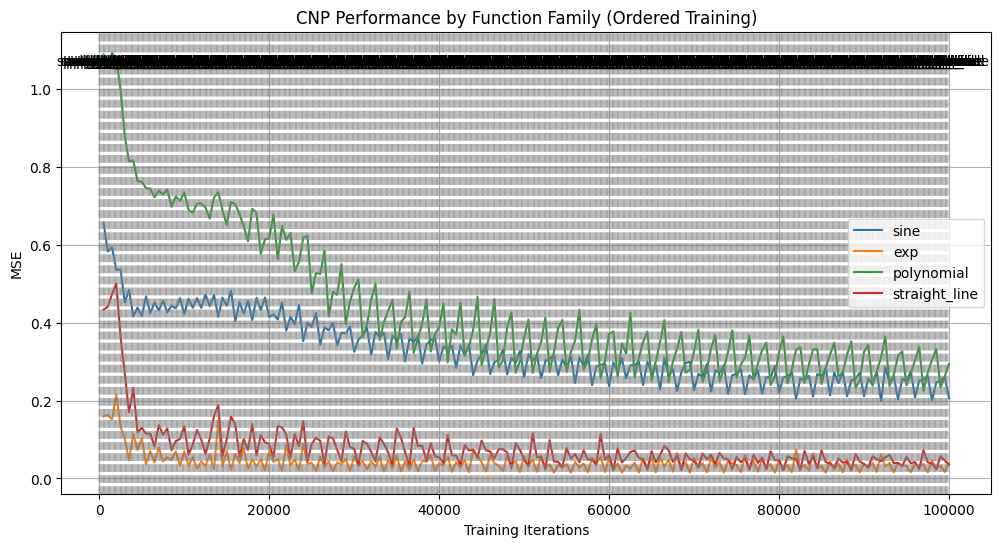


Final Evaluation:
  sine: MSE = 0.2063
sine test MSE: 0.2063


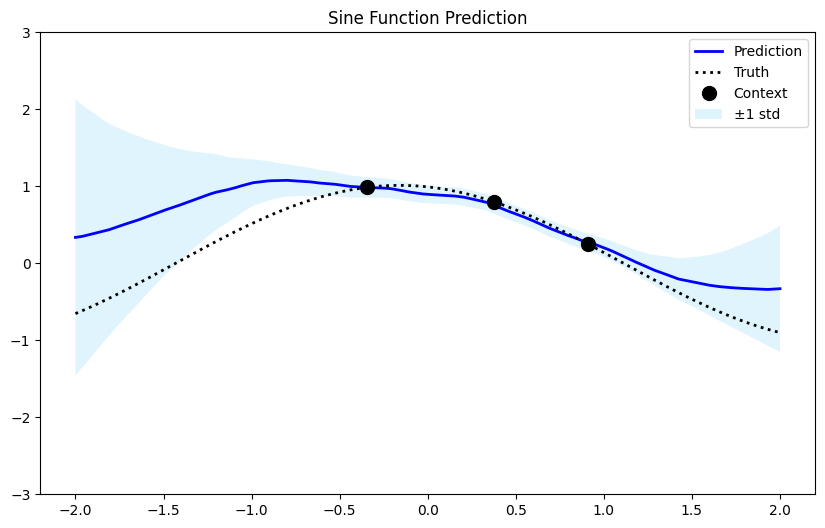

  exp: MSE = 0.0392
exp test MSE: 0.0392


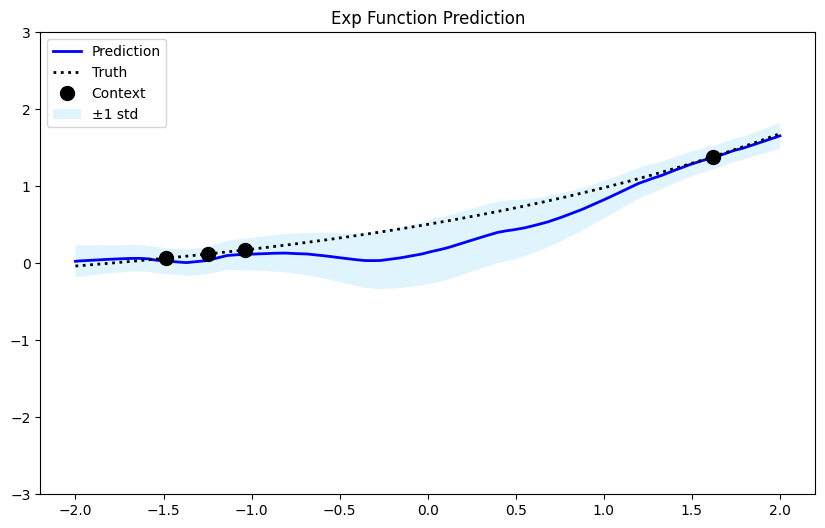

  polynomial: MSE = 0.2937
polynomial test MSE: 0.2937


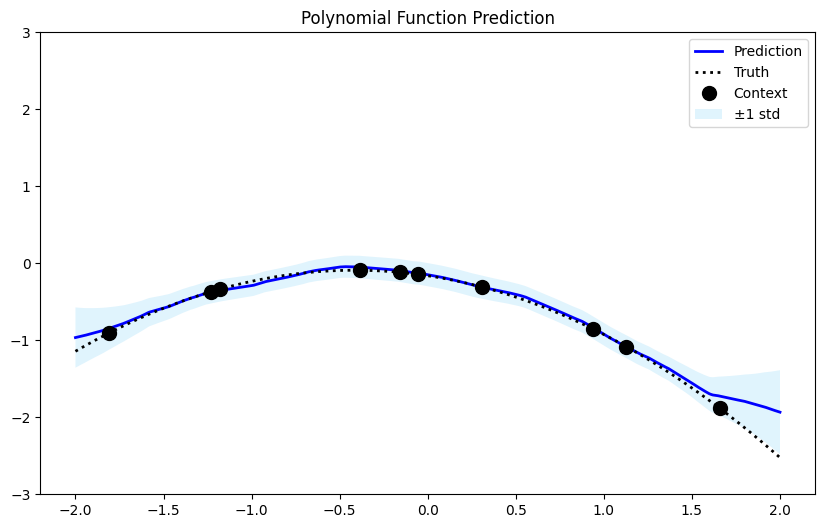

  straight_line: MSE = 0.0354
straight_line test MSE: 0.0354


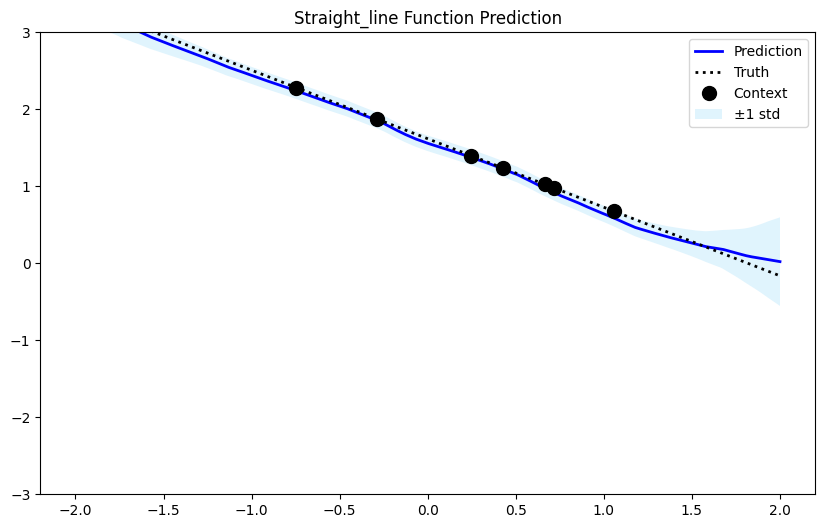

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data."""

        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1)) * 4 - 2)  # unif[-2, 2]

        if function_family is None:
            function_family = random.choice(self._function_families)

        if function_family == FunctionFamily.SINE:
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
BLOCK_SIZE = 100  # Number of iterations per function family
EVAL_AFTER = 500  # Evaluate every 500 iterations
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100

# Create fixed test datasets for each function family
fixed_test_datasets = {}
function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Initialize test data generators
test_readers = {
    family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
    for family in function_families
}

# Generate fixed test datasets
for family in function_families:
    fixed_test_datasets[family] = [
        test_readers[family].generate_curves(family)[0]
        for _ in range(NUM_TEST_TASKS)
    ]

# Model and Optimizer
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_blocks = []
family_mses = {family: [] for family in function_families}
current_family = None

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on test datasets and returns average MSE."""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)

    if family_name is not None:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")

    return avg_mse

print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {TRAINING_ITERATIONS} iterations with {BLOCK_SIZE}-iteration blocks")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

# Define the fixed order of function families
ordered_families = [
    FunctionFamily.STRAIGHT_LINE,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.EXP,
    FunctionFamily.SINE
]

# Calculate how many full cycles we'll do
num_families = len(ordered_families)
iterations_per_family = BLOCK_SIZE
iterations_per_cycle = num_families * iterations_per_family
num_full_cycles = TRAINING_ITERATIONS // iterations_per_cycle
remaining_iterations = TRAINING_ITERATIONS % iterations_per_cycle

for it in range(TRAINING_ITERATIONS):
    # Determine current family based on iteration number
    cycle_position = it % iterations_per_cycle
    family_index = cycle_position // iterations_per_family
    current_family = ordered_families[family_index]

    # Generate training batch from current family
    data_train, _ = train_reader.generate_curves(current_family)

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation (every EVAL_AFTER iterations)
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1} (Current family: {current_family}):")
        current_mses = {}
        total_mse = 0.0

        # Evaluate on all function families
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print(f"Average MSE across all families: {avg_mse:.4f}")

# Plot training curves per family with vertical lines showing family boundaries
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_blocks, family_mses[family], label=family)

# Add vertical lines for family boundaries
for cycle_start in range(0, TRAINING_ITERATIONS, iterations_per_cycle):
    for i in range(num_families):
        boundary = cycle_start + i * iterations_per_family
        if boundary < training_blocks[-1]:
            plt.axvline(boundary, color='gray', linestyle='--', alpha=0.3)
            # Add family labels
            if boundary < training_blocks[-1] and i < num_families - 1:
                plt.text(boundary + iterations_per_family/2, plt.ylim()[1]*0.95,
                        ordered_families[i], ha='center', va='top')

plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family (Ordered Training)')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation and visualization
print("\nFinal Evaluation:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    # Evaluate
    test_mse = evaluate_model(model, fixed_test_datasets[family], family)
    print(f"{family} test MSE: {test_mse:.4f}")

    # Visualize
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data."""
        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            x_values = torch.linspace(-2, 2, num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            x_values = (torch.rand((self._batch_size, num_target + num_context, 1)) * 4 - 2)

        if function_family is None:
            function_family = random.choice(self._function_families)

        if function_family == FunctionFamily.SINE:
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)
        elif function_family == FunctionFamily.EXP:
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift
        elif function_family == FunctionFamily.POLYNOMIAL:
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2
        elif function_family == FunctionFamily.STRAIGHT_LINE:
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept

        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values
            target_y = y_values
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])

    def forward(self, context_x, context_y):
        x = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size = x.shape[:2]
        x = x.view(batch_size * set_size, -1)
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        return x.view(batch_size, set_size, -1).mean(dim=1)

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])

    def forward(self, representation, target_x):
        rep = representation.unsqueeze(1).repeat(1, target_x.shape[1], 1)
        x = torch.cat((rep, target_x), dim=-1)
        batch_size, set_size = x.shape[:2]
        x = x.view(batch_size * set_size, -1)
        for linear in self.linears[:-1]:
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        return torch.distributions.Normal(mu, sigma), mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super().__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        return (dist.log_prob(target_y)) if target_y is not None else None, mu, sigma

class FixedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))

    def __len__(self):
        return len(self.buffer)

# Hyperparameters
TRAINING_ITERATIONS = 100000
BLOCK_SIZE = 100
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100
REPLAY_BUFFER_SIZE = 100  # Fixed buffer size of 100
RL_REPLAY_BATCH = 32
RL_UPDATE_FREQ = 50

# Initialize everything
function_families = [FunctionFamily.SINE, FunctionFamily.EXP,
                    FunctionFamily.POLYNOMIAL, FunctionFamily.STRAIGHT_LINE]
family_to_idx = {fam: i for i, fam in enumerate(function_families)}
ordered_families = [FunctionFamily.STRAIGHT_LINE, FunctionFamily.POLYNOMIAL,
                   FunctionFamily.EXP, FunctionFamily.SINE]

# Create test datasets
test_readers = {fam: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, True) for fam in function_families}
fixed_test_datasets = {fam: [test_readers[fam].generate_curves(fam)[0] for _ in range(NUM_TEST_TASKS)] for fam in function_families}

# Model setup
model = DeterministicModel(
    [2, 128, 128, 128, 128],
    [128 + 1, 128, 128, 2]
)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
replay_buffer = FixedReplayBuffer(REPLAY_BUFFER_SIZE)  # Single shared buffer
train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, False)

# Training statistics
mse_values = []
training_blocks = []
family_mses = {fam: [] for fam in function_families}
current_rewards = {fam: 0 for fam in function_families}
rl_rewards = {fam: 0 for fam in function_families}

def evaluate_model(model, test_datasets, family_name=None):
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)
    if family_name:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")
    return avg_mse

print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

for it in range(TRAINING_ITERATIONS):
    # Determine current family
    family_index = (it // BLOCK_SIZE) % len(ordered_families)
    current_family = ordered_families[family_index]

    # Training step
    data_train, _ = train_reader.generate_curves(current_family)
    log_prob, pred_y, _ = model(data_train.query, data_train.target_y)

    with torch.no_grad():
        error = torch.mean((pred_y - data_train.target_y)**2).item()
        reward = 1.0 / (1.0 + error)
        current_rewards[current_family] = reward

    # Store in shared buffer
    replay_buffer.push((data_train.query, data_train.target_y, current_family))

    optimizer.zero_grad()
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # RL update from shared buffer
    if it % RL_UPDATE_FREQ == 0 and len(replay_buffer) > RL_REPLAY_BATCH:
        batch = replay_buffer.sample(RL_REPLAY_BATCH)
        queries, target_ys, families = zip(*batch)

        log_probs = []
        new_rewards = []

        for query, target_y, family in zip(queries, target_ys, families):
            log_prob, pred_y, _ = model(query, target_y)
            log_probs.append(log_prob.mean())

            with torch.no_grad():
                error = torch.mean((pred_y - target_y)**2).item()
                reward = 1.0 / (1.0 + error)
                new_rewards.append(reward)
                rl_rewards[family] = reward

        loss = -torch.mean(torch.stack(log_probs))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1} (Current family: {current_family}):")
        print("Current rewards:")
        for fam in function_families:
            print(f"  {fam}: {current_rewards[fam]:.4f}")

        if it % RL_UPDATE_FREQ == 0:
            print("\nRL batch rewards:")
            for fam in function_families:
                print(f"  {fam}: {rl_rewards[fam]:.4f}")

        # Evaluation on test sets
        current_mses = {}
        total_mse = 0.0
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family])
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print("\nTest MSE per family:")
        for fam, mse in current_mses.items():
            print(f"  {fam}: {mse:.4f}")

        print(f"\nAverage MSE: {avg_mse:.4f}")
        print(f"Replay buffer size: {len(replay_buffer)}")

# Plot training curves per family with vertical lines showing family boundaries
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_blocks, family_mses[family], label=family)

# Add vertical lines for family boundaries
iterations_per_cycle = len(ordered_families) * BLOCK_SIZE
for cycle_start in range(0, TRAINING_ITERATIONS, iterations_per_cycle):
    for i in range(len(ordered_families)):
        boundary = cycle_start + i * BLOCK_SIZE
        if boundary < training_blocks[-1]:
            plt.axvline(boundary, color='gray', linestyle='--', alpha=0.3)
            # Add family labels
            if boundary < training_blocks[-1] and i < len(ordered_families) - 1:
                plt.text(boundary + BLOCK_SIZE/2, plt.ylim()[1]*0.95,
                        ordered_families[i], ha='center', va='top')

plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family with Prioritized Replay')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation and visualization
print("\nFinal Evaluation:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    # Evaluate
    test_mse = evaluate_model(model, fixed_test_datasets[family], family)
    print(f"{family} test MSE: {test_mse:.4f}")

    # Visualize
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

Starting training at 2025-04-11 18:55:59

Evaluation at iteration 500 (Current family: straight_line):
Current rewards:
  sine: 0.6237
  exp: 0.7855
  polynomial: 0.4335
  straight_line: 0.9307

Test MSE per family:
  sine: 0.6547
  exp: 0.1585
  polynomial: 1.0882
  straight_line: 0.4328

Average MSE: 0.5836
Replay buffer size: 100

Evaluation at iteration 1000 (Current family: polynomial):
Current rewards:
  sine: 0.8303
  exp: 0.7230
  polynomial: 0.4780
  straight_line: 0.9172

Test MSE per family:
  sine: 0.5811
  exp: 0.1639
  polynomial: 1.0581
  straight_line: 0.4377

Average MSE: 0.5602
Replay buffer size: 100

Evaluation at iteration 1500 (Current family: exp):
Current rewards:
  sine: 0.8406
  exp: 0.7365
  polynomial: 0.3459
  straight_line: 0.8614

Test MSE per family:
  sine: 0.6011
  exp: 0.1519
  polynomial: 1.0943
  straight_line: 0.4714

Average MSE: 0.5797
Replay buffer size: 100

Evaluation at iteration 2000 (Current family: sine):
Current rewards:
  sine: 0.8941
  